Using Pythia models of various sizes. 

Compares base models with SFT models and DPO finetuned models. 

* Analyse perplexity
* Visualise distribution of token predictions.



## Import stuff

In [2]:
import torch
import numpy as np
import json
import os
from matplotlib import pyplot as plt

In [3]:
torch.cuda.is_available()

True

# Load data

Load data for relevant sections below. 

Notes: 

data['all_logprobs'] contains all logprobs for correct token. 
It is max_docs arrays long. Each array is some length <= context, dtype=float32.  

data['mean_probs'] contains probabilities for each token from dictionary, averaged every 500 docs for memory purposes. 
It is max_docs/500 arrays long. Each array is shape (X,dictionary_size)

## 70m

### Perplexity and entropy

In [5]:
base_70m_perplexity_path = f'{os.path.dirname(os.getcwd())}/results/pythia70m-base-perplexity.json'
sft_70m_perplexity_path = f'{os.path.dirname(os.getcwd())}/results/pythia70m-sft-perplexity.json'
dpo_70m_perplexity_path = f'{os.path.dirname(os.getcwd())}/results/pythia70m-dpo-perplexity.json'

with open(base_70m_perplexity_path,'r') as file: 
    base_70m_perplexity_data = json.loads(file.read())

with open(sft_70m_perplexity_path,'r') as file: 
    sft_70m_perplexity_data = json.loads(file.read())

with open(dpo_70m_perplexity_path,'r') as file: 
    dpo_70m_perplexity_data = json.loads(file.read())

In [6]:
base_70m_perplexity_data

{'entropy': 2.9086456298828125, 'perplexity': 18.331954956054688}

In [7]:
sft_70m_perplexity_data

{'entropy': 3.4037113189697266, 'perplexity': 30.075511932373047}

In [8]:
dpo_70m_perplexity_data

{'entropy': 3.4105262756347656, 'perplexity': 30.281177520751953}

## Entropy

In [26]:
base_70m_data["entropy"][0].mean()

nan

In [27]:
sft_70m_data["entropy"][0].mean()

nan

In [28]:
dpo_70m_data["entropy"][0].mean()

nan

In [31]:
base_70m_data["entropy"][0]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

### Plot CDF of average token probability on The Pile val

In [9]:
# load data calculated for pythia70m
base_70m_data_path = f'{os.path.dirname(os.getcwd())}/outputs/pythia70m-base-calculation_data10000pc.p'
base_70m_data = torch.load(base_70m_data_path)

sft_70m_data_path = f'{os.path.dirname(os.getcwd())}/outputs/pythia70m-sft-calculation_data10000pc.p'
sft_70m_data = torch.load(sft_70m_data_path)

dpo_70m_data_path = f'{os.path.dirname(os.getcwd())}/outputs/pythia70m-dpo-calculation_data10000pc.p'
dpo_70m_data = torch.load(dpo_70m_data_path)

In [10]:
probs_base_70m = np.concatenate(base_70m_data["mean_probs"]).mean(0)
probs_base_70m_list = list(probs_base_70m)

probs_sft_70m = np.concatenate(sft_70m_data["mean_probs"]).mean(0)
probs_sft_70m.shape# (50304,)
probs_sft_70m_list = list(probs_sft_70m)

probs_dpo_70m = np.concatenate(dpo_70m_data["mean_probs"]).mean(0)
probs_dpo_70m_list = list(probs_dpo_70m)

In [11]:
base_70m_order = np.argsort(probs_base_70m_list)
sft_70m_order = np.argsort(probs_sft_70m_list)
dpo_70m_order = np.argsort(probs_dpo_70m_list)

In [12]:
# probs_base_list.sort(reverse=True) # doesn't copy to memory
probs_base_70m_list_sorted = sorted(probs_base_70m_list, reverse=True)
probs_sft_70m_list_sorted = sorted(probs_sft_70m_list, reverse=True) 
probs_dpo_70m_list_sorted = sorted(probs_dpo_70m_list, reverse=True)

In [13]:
base_70m_cdf = np.cumsum(probs_base_70m_list_sorted) 
sft_70m_cdf = np.cumsum(probs_sft_70m_list_sorted)
dpo_70m_cdf = np.cumsum(probs_dpo_70m_list_sorted)

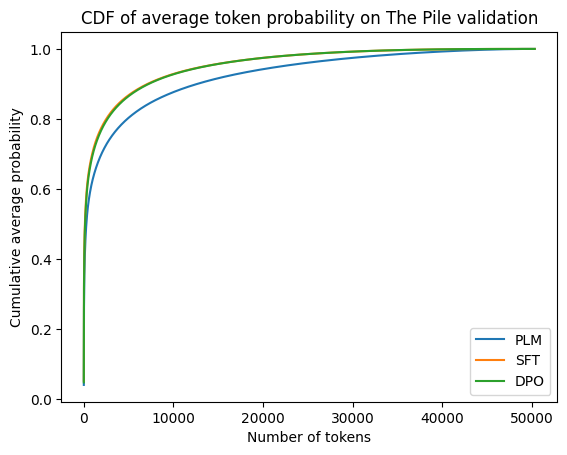

In [20]:
plt.plot(base_70m_cdf, label="PLM")
plt.plot(sft_70m_cdf, label="SFT")
plt.plot(dpo_70m_cdf, label="DPO")

plt.title("CDF of average token probability on The Pile validation")
plt.xlabel("Number of tokens")
plt.ylabel("Cumulative average probability")
plt.legend()

(0.8, 1.0)

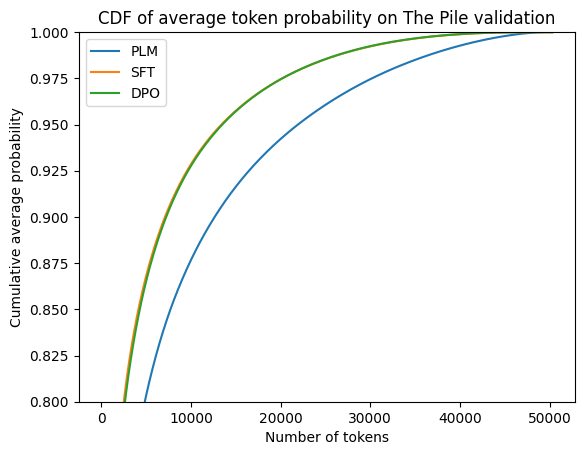

In [21]:
plt.plot(base_70m_cdf, label="PLM")
plt.plot(sft_70m_cdf, label="SFT")
plt.plot(dpo_70m_cdf, label="DPO")

plt.title("CDF of average token probability on The Pile validation")
plt.xlabel("Number of tokens")
plt.ylabel("Cumulative average probability")
plt.legend()
plt.ylim((0.8,1))

In [22]:
# 50304 tokens in total. 
tot_toks = len(base_70m_cdf)

In [23]:
def first(the_iterable, condition = lambda x: True):
    for idx, cumprob in enumerate(the_iterable):
        if condition(cumprob):
            return idx

In [24]:
print("Proportion of total tokenizer where sum of average token probabilities at 70%: ")
print(f"Pythia70m base model: {first(base_70m_cdf, lambda i: i > 0.7)/tot_toks}")
print(f"Pythia70m sft model: {first(sft_70m_cdf, lambda i: i > 0.7)/tot_toks}")
print(f"Pythia70m dpo model: {first(dpo_70m_cdf, lambda i: i > 0.7)/tot_toks}")

Proportion of total tokenizer where sum of average token probabilities at 70%: 
Pythia70m base model: 0.0391022582697201
Pythia70m sft model: 0.01850747455470738
Pythia70m dpo model: 0.0200779262086514


In [25]:
print("Proportion of total tokenizer where sum of average token probabilities at 90%: ")
print(f"Pythia70m base model: {first(base_70m_cdf, lambda i: i > 0.9)/tot_toks}")
print(f"Pythia70m sft model: {first(sft_70m_cdf, lambda i: i > 0.9)/tot_toks}")
print(f"Pythia70m dpo model: {first(dpo_70m_cdf, lambda i: i > 0.9)/tot_toks}")

Proportion of total tokenizer where sum of average token probabilities at 90%: 
Pythia70m base model: 0.25135178117048346
Pythia70m sft model: 0.14118161577608143
Pythia70m dpo model: 0.1438255407124682


## 410m

In [4]:
base_410m_perplexity_path = f'{os.path.dirname(os.getcwd())}/results/pythia410m-base-perplexity.json'
sft_410m_perplexity_path = f'{os.path.dirname(os.getcwd())}/results/pythia410m-sft-perplexity.json'
dpo_410m_perplexity_path = f'{os.path.dirname(os.getcwd())}/results/pythia410m-dpo-perplexity.json'

with open(base_410m_perplexity_path,'r') as file: 
    base_410m_perplexity_data = json.loads(file.read())

with open(sft_410m_perplexity_path,'r') as file: 
    sft_410m_perplexity_data = json.loads(file.read())

with open(dpo_410m_perplexity_path,'r') as file: 
    dpo_410m_perplexity_data = json.loads(file.read())


In [5]:
# load data calculated for pythia410m
base_410m_data_path = f'{os.path.dirname(os.getcwd())}/outputs/pythia410m-base-calculation_data10000pc.p'
base_410m_data = torch.load(base_410m_data_path)

sft_410m_data_path = f'{os.path.dirname(os.getcwd())}/outputs/pythia410m-sft-calculation_data10000pc.p'
sft_410m_data = torch.load(sft_410m_data_path)

dpo_410m_data_path = f'{os.path.dirname(os.getcwd())}/outputs/pythia410m-dpo-calculation_data10000pc.p'
dpo_410m_data = torch.load(dpo_410m_data_path)

### Prediction perplexity and entropy

In [6]:
base_410m_perplexity_data

{'entropy': 2.223323345184326, 'perplexity': 9.237980842590332}

In [7]:
sft_410m_perplexity_data

{'entropy': 2.2711644172668457, 'perplexity': 9.690678596496582}

In [8]:
dpo_410m_perplexity_data

{'entropy': 2.3046715259552, 'perplexity': 10.020886421203613}

### Entropy

In [9]:
base_410m_data["entropy"][0].mean()

2.5219889

In [10]:
sft_410m_data["entropy"][0].mean()

2.276319

In [11]:
dpo_410m_data["entropy"][0].mean()

2.178565

### Plot CDF of average token probability on The Pile val

In [23]:
# load data calculated for pythia410m
# base_410m_data_path = f'{os.path.dirname(os.getcwd())}/outputs/calculation_data_all_20000-pythia410m-base.p'
# base_410m_data = torch.load(base_410m_data_path)

# sft_410m_data_path = f'{os.path.dirname(os.getcwd())}/outputs/calculation_data_all_20000-pythia410m-sft.p'
# sft_410m_data = torch.load(sft_410m_data_path)

# dpo_410m_data_path = f'{os.path.dirname(os.getcwd())}/outputs/calculation_data_all_20000-pythia410m-dpo.p'
# dpo_410m_data = torch.load(dpo_410m_data_path)

In [24]:
probs_base_410m = np.concatenate(base_410m_data["mean_probs"]).mean(0)
probs_base_410m_list = list(probs_base_410m)

probs_sft_410m = np.concatenate(sft_410m_data["mean_probs"]).mean(0)
probs_sft_410m.shape# (50304,)
probs_sft_410m_list = list(probs_sft_410m)

probs_dpo_410m = np.concatenate(dpo_410m_data["mean_probs"]).mean(0)
probs_dpo_410m_list = list(probs_dpo_410m)

In [25]:
base_410m_order = np.argsort(probs_base_410m_list)
sft_410m_order = np.argsort(probs_sft_410m_list)
dpo_410m_order = np.argsort(probs_dpo_410m_list)

In [26]:
probs_base_410m_list_sorted = sorted(probs_base_410m_list, reverse=True)
probs_sft_410m_list_sorted = sorted(probs_sft_410m_list, reverse=True) 
probs_dpo_410m_list_sorted = sorted(probs_dpo_410m_list, reverse=True)

In [27]:
base_410m_cdf = np.cumsum(probs_base_410m_list_sorted)
sft_410m_cdf = np.cumsum(probs_sft_410m_list_sorted)
dpo_410m_cdf = np.cumsum(probs_dpo_410m_list_sorted)

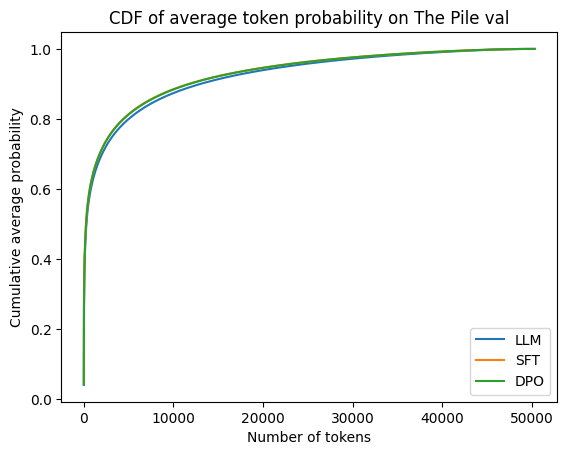

In [37]:
plt.plot(base_410m_cdf, label="LLM")
plt.plot(sft_410m_cdf, label="SFT")
plt.plot(dpo_410m_cdf, label="DPO")

plt.title("CDF of average token probability on The Pile val")
plt.xlabel("Number of tokens")
plt.ylabel("Cumulative average probability")
plt.legend()

(0.8, 1.0)

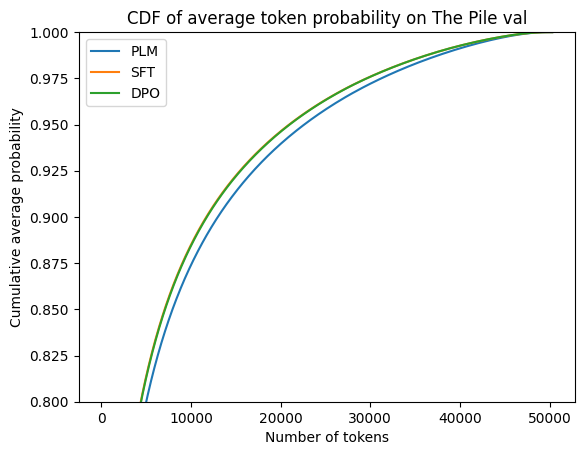

In [38]:
plt.plot(base_410m_cdf, label="PLM")
plt.plot(sft_410m_cdf, label="SFT")
plt.plot(dpo_410m_cdf, label="DPO")

plt.title("CDF of average token probability on The Pile val")
plt.xlabel("Number of tokens")
plt.ylabel("Cumulative average probability")
plt.legend()
plt.ylim((0.8,1))

In [30]:
# 50304 tokens in total. 
tot_toks = len(base_410m_cdf)

In [31]:
def first(the_iterable, condition = lambda x: True):
    for idx, cumprob in enumerate(the_iterable):
        if condition(cumprob):
            return idx

In [32]:
print("Proportion of total tokenizer where sum of average token probabilities at 70%: ")
print(f"Pythia410m base model: {first(base_410m_cdf, lambda i: i > 0.7)/tot_toks}")
print(f"Pythia410m sft model: {first(sft_410m_cdf, lambda i: i > 0.7)/tot_toks}")
print(f"Pythia410m dpo model: {first(dpo_410m_cdf, lambda i: i > 0.7)/tot_toks}")

Proportion of total tokenizer where sum of average token probabilities at 70%: 
Pythia410m base model: 0.040454039440203565
Pythia410m sft model: 0.034967398218829514
Pythia410m dpo model: 0.03514631043256997


In [33]:
print("Proportion of total tokenizer where sum of average token probabilities at 90%: ")
print(f"Pythia410m base model: {first(base_410m_cdf, lambda i: i > 0.9)/tot_toks}")
print(f"Pythia410m sft model: {first(sft_410m_cdf, lambda i: i > 0.9)/tot_toks}")
print(f"Pythia410m dpo model: {first(dpo_410m_cdf, lambda i: i > 0.9)/tot_toks}")

Proportion of total tokenizer where sum of average token probabilities at 90%: 
Pythia410m base model: 0.25840887404580154
Pythia410m sft model: 0.232804548346056
Pythia410m dpo model: 0.23411657124681934


### Confidence of next prediction

In [34]:
def Average(lst):
    return sum(lst) / len(lst)

In [35]:
base_docs_avgs = [base_410m_data["next_pred_confidence"][i].mean() for i in range(len(base_410m_data["next_pred_confidence"]))]
sft_docs_avgs = [sft_410m_data["next_pred_confidence"][i].mean() for i in range(len(dpo_410m_data["next_pred_confidence"]))]
dpo_docs_avgs = [sft_410m_data["next_pred_confidence"][i].mean() for i in range(len(dpo_410m_data["next_pred_confidence"]))]

In [36]:
print(f"Base model average confidence: {Average(base_docs_avgs)}")
print(f"Sft model average confidence: {Average(sft_docs_avgs)}")
print(f"Dpo model average confidence: {Average(dpo_docs_avgs)}")

Base model average confidence: 0.5266247649542988
Sft model average confidence: 0.5577386160448193
Dpo model average confidence: 0.5577386160448193


## 160m

### Prediction perplexity and entropy

In [69]:

base_160m_perplexity_path = f'{os.path.dirname(os.getcwd())}/outputs/perplexity_20000-pythia160m-base.json'
sft_160m_perplexity_path = f'{os.path.dirname(os.getcwd())}/outputs/perplexity_20000-pythia160m-sft.json'
dpo_160m_perplexity_path = f'{os.path.dirname(os.getcwd())}/outputs/perplexity_20000-pythia160m-dpo.json'

with open(base_160m_perplexity_path,'r') as file: 
    base_160m_perplexity_data = json.loads(file.read())

with open(sft_160m_perplexity_path,'r') as file: 
    sft_160m_perplexity_data = json.loads(file.read())

with open(dpo_160m_perplexity_path,'r') as file: 
    dpo_160m_perplexity_data = json.loads(file.read())


In [70]:
base_160m_perplexity_data

{'entropy': 2.562896966934204, 'perplexity': 12.973346710205078}

In [71]:
sft_160m_perplexity_data

{'entropy': 2.7176992893218994, 'perplexity': 15.14543628692627}

In [72]:
dpo_160m_perplexity_data

{'entropy': 2.7781496047973633, 'perplexity': 16.089221954345703}

In [40]:
base_160m_perplexity_path = f'{os.path.dirname(os.getcwd())}/outputs/pythia160m-base-50000.json'
sft_160m_perplexity_path = f'{os.path.dirname(os.getcwd())}/outputs/pythia160m-sft-50000.json'
dpo_160m_perplexity_path = f'{os.path.dirname(os.getcwd())}/outputs/pythia160m-dpo-50000.json'

with open(base_160m_perplexity_path,'r') as file: 
    base_160m_perplexity_data = json.loads(file.read())

with open(sft_160m_perplexity_path,'r') as file: 
    sft_160m_perplexity_data = json.loads(file.read())

with open(dpo_160m_perplexity_path,'r') as file: 
    dpo_160m_perplexity_data = json.loads(file.read())


In [41]:
base_160m_perplexity_data

{'entropy': 2.588127851486206, 'perplexity': 13.304839134216309}

In [42]:
sft_160m_perplexity_data

{'entropy': 2.743051767349243, 'perplexity': 15.534319877624512}

In [43]:
dpo_160m_perplexity_data

{'entropy': 2.804750680923462, 'perplexity': 16.5229549407959}

### Plot CDF of average token probability on The Pile val

In [4]:
# load data calculated for pythia160m
base_160m_data_path = f'{os.path.dirname(os.getcwd())}/outputs/calculation_data_all_20000-pythia160m-base.p'
base_160m_data = torch.load(base_160m_data_path)

sft_160m_data_path = f'{os.path.dirname(os.getcwd())}/outputs/calculation_data_all_20000-pythia160m-sft.p'
sft_160m_data = torch.load(sft_160m_data_path)

dpo_160m_data_path = f'{os.path.dirname(os.getcwd())}/outputs/calculation_data_all_20000-pythia160m-dpo.p'
dpo_160m_data = torch.load(dpo_160m_data_path)

In [5]:
probs_base_160m = np.concatenate(base_160m_data["mean_probs"]).mean(0)
probs_base_160m_list = list(probs_base_160m)

probs_sft_160m = np.concatenate(sft_160m_data["mean_probs"]).mean(0)
probs_sft_160m.shape# (50304,)
probs_sft_160m_list = list(probs_sft_160m)

probs_dpo_160m = np.concatenate(dpo_160m_data["mean_probs"]).mean(0)
probs_dpo_160m_list = list(probs_dpo_160m)

In [6]:
base_160m_order = np.argsort(probs_base_160m_list)
sft_160m_order = np.argsort(probs_sft_160m_list)
dpo_160m_order = np.argsort(probs_dpo_160m_list)

In [7]:
probs_base_160m_list_sorted = sorted(probs_base_160m_list, reverse=True)
probs_sft_160m_list_sorted = sorted(probs_sft_160m_list, reverse=True) 
probs_dpo_160m_list_sorted = sorted(probs_dpo_160m_list, reverse=True)

In [8]:
base_160m_cdf = np.cumsum(probs_base_160m_list_sorted)
sft_160m_cdf = np.cumsum(probs_sft_160m_list_sorted)
dpo_160m_cdf = np.cumsum(probs_dpo_160m_list_sorted)

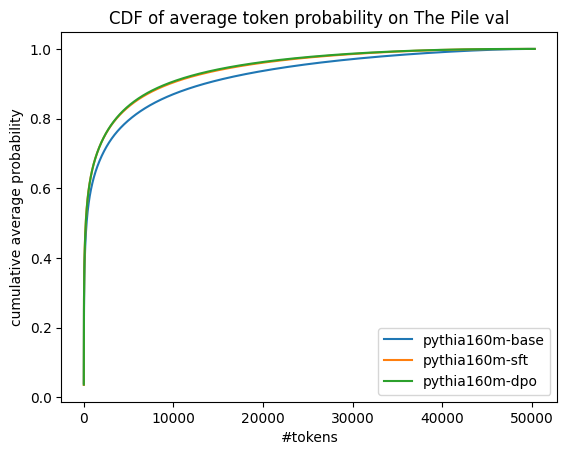

In [9]:
plt.plot(base_160m_cdf, label="pythia160m-base")
plt.plot(sft_160m_cdf, label="pythia160m-sft")
plt.plot(dpo_160m_cdf, label="pythia160m-dpo")

plt.title("CDF of average token probability on The Pile val")
plt.xlabel("#tokens")
plt.ylabel("cumulative average probability")
plt.legend()

(0.8, 1.0)

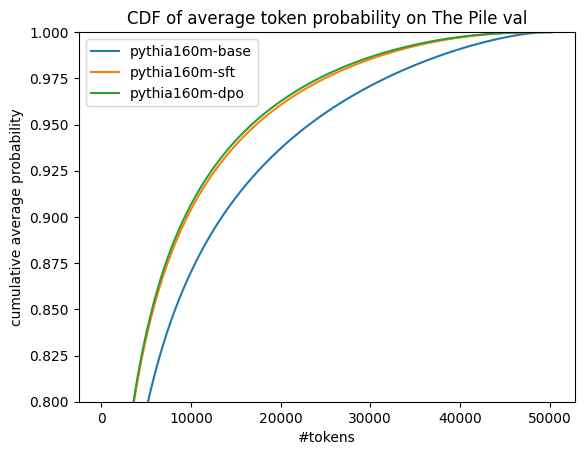

In [10]:
plt.plot(base_160m_cdf, label="pythia160m-base")
plt.plot(sft_160m_cdf, label="pythia160m-sft")
plt.plot(dpo_160m_cdf, label="pythia160m-dpo")

plt.title("CDF of average token probability on The Pile val")
plt.xlabel("#tokens")
plt.ylabel("cumulative average probability")
plt.legend()
plt.ylim((0.8,1))

In [13]:
# 50304 tokens in total. 
tot_toks = len(base_160m_cdf)

In [14]:
def first(the_iterable, condition = lambda x: True):
    for idx, cumprob in enumerate(the_iterable):
        if condition(cumprob):
            return idx

In [16]:
print("Proportion of total tokenizer where sum of average token probabilities at 70%: ")
print(f"Pythia160m base model: {first(base_160m_cdf, lambda i: i > 0.7)/tot_toks}")
print(f"Pythia160m sft model: {first(sft_160m_cdf, lambda i: i > 0.7)/tot_toks}")
print(f"Pythia160m dpo model: {first(dpo_160m_cdf, lambda i: i > 0.7)/tot_toks}")

Proportion of total tokenizer where sum of average token probabilities at 70%: 
Pythia70m base model: 0.042322678117048346
Pythia70m sft model: 0.029083174300254453
Pythia70m dpo model: 0.029103053435114504


In [15]:
print("Proportion of total tokenizer where sum of average token probabilities at 90%: ")
print(f"Pythia160m base model: {first(base_160m_cdf, lambda i: i > 0.9)/tot_toks}")
print(f"Pythia160m sft model: {first(sft_160m_cdf, lambda i: i > 0.9)/tot_toks}")
print(f"Pythia160m dpo model: {first(dpo_160m_cdf, lambda i: i > 0.9)/tot_toks}")

Proportion of total tokenizer where sum of average token probabilities at 90%: 
Pythia70m base model: 0.26743400127226463
Pythia70m sft model: 0.19052162849872772
Pythia70m dpo model: 0.1849952290076336


### Confidence of next prediction

In [30]:
def Average(lst):
    return sum(lst) / len(lst)

In [34]:
base_docs_avgs = [base_160m_data["next_pred_confidence"][i].mean() for i in range(len(base_160m_data["next_pred_confidence"]))]
sft_docs_avgs = [sft_160m_data["next_pred_confidence"][i].mean() for i in range(len(dpo_160m_data["next_pred_confidence"]))]
dpo_docs_avgs = [sft_160m_data["next_pred_confidence"][i].mean() for i in range(len(dpo_160m_data["next_pred_confidence"]))]

In [35]:
print(f"Base model average confidence: {Average(base_docs_avgs)}")
print(f"Sft model average confidence: {Average(sft_docs_avgs)}")
print(f"Dpo model average confidence: {Average(dpo_docs_avgs)}")

Base model average confidence: 0.4815965031362935
Sft model average confidence: 0.5533014396755518
Dpo model average confidence: 0.5533014396755518


## Look at some files

In [73]:
# look at files 
# len(base_70m_data['all_logprobs']) # 49996
# base_70m_data['all_logprobs'][0].shape # (1492,)
# base_70m_data['all_logprobs'][1]#.shape # (606,) 

# len(base_70m_data['mean_probs']) # 100
# base_70m_data['mean_probs'][0].shape # (2, 50304)
# base_70m_data['mean_probs'][0]

In [23]:
# len(base_160m_data["next_pred_confidence"]) # 19999
# base_160m_data["next_pred_confidence"][0].shape # (2, 1024) 
# base_160m_data["next_pred_confidence"][0]

array([[0.14247888, 0.25310037, 0.08056772, ..., 0.23367   , 0.37167594,
        0.35720518],
       [0.17651424, 0.10753624, 0.06734039, ..., 0.7057749 , 0.6575341 ,
        0.2121143 ]], dtype=float32)

## Other

In [ ]:
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
device = "cuda:0" 

In [ ]:
model_base = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-70m",).to(device)
model_sft = GPTNeoXForCausalLM.from_pretrained("lomahony/eleuther-pythia70m-hh-sft",).to(device)

tokenizer = AutoTokenizer.from_pretrained("lomahony/eleuther-pythia70m-hh-sft",)

In [ ]:
base_order

In [ ]:
tokenizer.convert_ids_to_tokens(base_order)

In [ ]:
probs_base_list[45000:]

In [ ]:
base_order[45000:]

In [ ]:
sft_order

In [ ]:
tokenizer.convert_ids_to_tokens(sft_order)

In [ ]:
probs_sft_list[45000:]

In [ ]:
sft_order[45000:]

## RW